[Open In Colab](https://colab.research.google.com/github/ibaiGorordo/Social-Distance-Feedback/blob/master/Part%202%20-%20Mask%20Detection/Face%20Mask%20Detection%20Inference%20Comparison/YOLOv4_tiny_Darknet_Mask_Detection.ipynb)

# DepthAI Tutorial: Training a Tiny YOLOv4 Object Detector with Your Own Data

<img src="https://docs.luxonis.com/images/depthai_logo.png" width="500">

Welcome to DepthAI! 

In this tutorial we will train an object detector using the Tiny Yolo v4 model. This model will run on our DepthAI Myriad X modules.

The model is pretrained on the COCO dataset. The framework used for training is Darknet.
Will run through the following steps:


*   Install the libraries (Darknet , etc.)
*   Clone the github repo and replace the repo training data with your data (from google drive or from own repo - which is faster)
*   Train the model on the new images
*   Run inference on a few images to see what the model can detect
*   Convert the model to OpenVINO Intermediate Representation
*   To run the model on DepthAI modules, compile the IR obtained above to a .blob file 

You can make a copy of this tutorial: File-> Save a copy in Drive

Note: the model training can be run with the repo images of medical masks if you choose to skip the customization part for your own images just to see how the training and the rest of the steps work

In [1]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [2]:
#take a look at the kind of GPU we have
!nvidia-smi

Fri Feb  5 16:56:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Installing Darknet for YOLOv4 on Colab




In [13]:
%cd /content/
%rm -rf darknet

/content


In [14]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 14691, done.
remote: Total 14691 (delta 0), reused 0 (delta 0), pack-reused 14691
Receiving objects: 100% (14691/14691), 13.25 MiB | 24.48 MiB/s, done.
Resolving deltas: 100% (9994/9994), done.


In [15]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

/content/darknet


**IMPORTANT! If you're not using a K80 GPU, then uncomment the sed command and replace the arch and code with that matching your GPU. A list can be found [here](http://arnon.dk/matching-sm-architectures-arch-and-gencode-for-various-nvidia-cards/).**

In [16]:
#install environment from the Makefile
%cd darknet/
# compute_30, sm_30 for Tesla K80
# compute_75, sm_75 for Tesla T4
!sed -i 's/ARCH= -gencode arch=compute_75,code=sm_75/g' Makefile

#install environment from the Makefile
#note if you are on Colab Pro this works on a P100 GPU
#if you are on Colab free, you may need to change the Makefile for the K80 GPU
#this goes for any GPU, you need to change the Makefile to inform darknet which GPU you are running on.
!make

[Errno 2] No such file or directory: 'darknet/'
/content/darknet
sed: -e expression #1, char 45: unterminated `s' command
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.c

## Clone a helper repo
It makes training the medical mask detecting model easy.
In order to train on your own data, this repo can be used as a blueprint. 
Changes to some files need to be made according to own data, but it is nothing complicated.

In [22]:
%cd /content
%rm -rf DeepCourse/

/content


In [23]:
repo_url = 'https://github.com/Elkayamacc/DeepCourse'
import os
%cd /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url}
%cd {repo_dir_path}


/content
Cloning into 'DeepCourse'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 31 (delta 4), reused 13 (delta 3), pack-reused 17
Unpacking objects: 100% (31/31), done.
/content/DeepCourse


In [24]:
#define utility function
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [26]:
%rm -rf /content/DeepCourse/obj/
#make dir obj
!mkdir /content/DeepCourse/obj/
!cp -rf '/content/DeepCourse/obj1.zip' '/content/DeepCourse/obj/'
!cp -rf '/content/DeepCourse/obj2.zip' '/content/DeepCourse/obj/'

In [27]:
!unzip /content/DeepCourse/obj/obj1.zip -d /content/DeepCourse/obj/
!unzip /content/DeepCourse/obj/obj2.zip -d /content/DeepCourse/obj/

Streaming output truncated to the last 5000 lines.
  inflating: /content/DeepCourse/obj/maksssksksss314_png.rf.9df37b0acf81d72959caea8eb12ba00e.txt  
  inflating: /content/DeepCourse/obj/maksssksksss315_png.rf.31054af7130c0daf436d5eb6096044a0.jpg  
  inflating: /content/DeepCourse/obj/maksssksksss315_png.rf.31054af7130c0daf436d5eb6096044a0.txt  
  inflating: /content/DeepCourse/obj/maksssksksss315_png.rf.9d2e19c9ab3477807cae4f4c64941651.jpg  
  inflating: /content/DeepCourse/obj/maksssksksss315_png.rf.9d2e19c9ab3477807cae4f4c64941651.txt  
  inflating: /content/DeepCourse/obj/maksssksksss315_png.rf.f8acefc8e8ae5715cda97d35606f2f1e.jpg  
  inflating: /content/DeepCourse/obj/maksssksksss315_png.rf.f8acefc8e8ae5715cda97d35606f2f1e.txt  
  inflating: /content/DeepCourse/obj/maksssksksss316_png.rf.324ae96261fbe3733d850e4fbe92e5c1.jpg  
  inflating: /content/DeepCourse/obj/maksssksksss316_png.rf.324ae96261fbe3733d850e4fbe92e5c1.txt  
  inflating: /content/DeepCourse/obj/maksssksksss316_png.r

## Change the labels in obj.names to our current labels

In [28]:
labels_path = '/content/DeepCourse/obj.names'
#make a list of your labels
labels = ['no mask','mask']
# labels = ['good','bad']

with open(labels_path, 'w') as f:

    f.write('\n'.join(labels))

#check that the labels file is correct
!cat /content/DeepCourse/obj.names

no mask
mask

In [29]:
%cd /content/DeepCourse

/content/DeepCourse


## Change the number of classes in obj.data.
The paths are relative so no change there as long as the folder/file structure/names are not changed.

In [30]:
import re
objdata = '/content/DeepCourse/obj.data'
with open(objdata) as f:
    s = f.read()

#the number of classes is equal to the number of labels
num_classes = len(labels)   
s = re.sub('classes = \d*','classes = ' + str(num_classes),s)

with open(objdata, 'w') as f:
  f.write(s)
!cat /content/DeepCourse/obj.data

classes= 2
train  = /content/DeepCourse/train.txt
valid  = /content/DeepCourse/valid.txt
names = /content/DeepCourse/obj.names
backup = backup/

In [31]:
#in this case we use 6 percent as the number of images for testing.
#double clicking on the train or test text files will open the file in a new
#tab in colab and display the content.
!python3 folder2textYolo.py 75 20  /content/DeepCourse/obj

Your image file extension is: .jpg
Number of images: 2831
Number of images used for training 2123
Number of images used for validation 566
Number of images used for testing 142


### Now that we see which parameters are of importance, let's modify them according to our dataset.

In [32]:
# set the number of max_batches - min 2000 per class:
max_batch=4000
# calculate the 2 steps values:
step1 = 0.8 * max_batch
step2 = 0.9 * max_batch

# we also need to adjust the number of classes and a parameter called filter size 
# that are both is inside the model structure

# num_classes = len(labels)
num_filters = (num_classes + 5) * 3


#cfg_file = '/content/DeepCourse/yolov3-tiny_obj.cfg'
cfg_file = '/content/DeepCourse/yolov4-tiny.cfg'

with open(cfg_file) as f:
    s = f.read()
# (re.sub('[a-z]*@', 'ABC@', s))
s = re.sub('max_batches = \d*','max_batches = '+str(max_batch),s)
s = re.sub('steps=\d*,\d*','steps='+"{:.0f}".format(step1)+','+"{:.0f}".format(step2),s)
s = re.sub('classes=\d*','classes='+str(num_classes),s)
s = re.sub('pad=1\nfilters=\d*','pad=1\nfilters='+"{:.0f}".format(num_filters),s)
# pad=1\nfilters=\d\d
# s = re.sub('CUDNN=0','CUDNN=1',s)
# s = re.sub('OPENCV=0','OPENCV=1',s)

with open(cfg_file, 'w') as f:
  # s = re.sub('GPU=0','GPU=1',s)
  f.write(s)


## Start the model training

In [33]:
%cd ../darknet/
!./darknet detector train /content/DeepCourse/obj.data /content/DeepCourse/yolov4-tiny.cfg /content/DeepCourse/yolov4-tiny.conv.29 -dont_show -ext_output -map

Streaming output truncated to the last 5000 lines.
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.794698), count: 143, class_loss = 0.642818, iou_loss = 8.348272, total_loss = 8.991090 
 total_bbox = 743522, rewritten_bbox = 0.080428 % 

 (next mAP calculation at 3640 iterations) 

 Tensor Cores are used.
 Last accuracy mAP@0.5 = 86.55 %, best = 86.61 % 
 3511: 0.386172, 0.392991 avg loss, 0.000261 rate, 0.653074 seconds, 224704 images, 0.114437 hours left
Loaded: 0.000044 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.856320), count: 56, class_loss = 0.052534, iou_loss = 0.447018, total_loss = 0.499552 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.810764), count: 149, class_loss = 0.469979, iou_loss = 10.708076, total_loss = 11.178056 
 total_bbox = 743727, rewritten_bbox = 0.080406 % 

 (next mAP calculation at 3640 iterations) 

 Tensor Cores are used.
 Last accuracy mA

In [ ]:
#In Case we want to load weights instead of train (from another training of mine)
#!./darknet detector map /content/DeepCourse/obj.data /content/DeepCourse/yolov4-tiny.cfg "/content/drive/MyDrive/Tinyyolo/Tiny4BestWeights/backup/yolov4-tiny_best.weights" -points 0


SyntaxError: ignored

In [ ]:
#Test the weights from training before:
#!./darknet detector test /content/DeepCourse/obj.data  /content/DeepCourse/yolov4-tiny.cfg  "/content/drive/MyDrive/Tinyyolo/Tiny4BestWeights/backup/yolov4-tiny_best.weights" /content/DeepCourse/obj/maksssksksss171_png.rf.e9a1d65f711fb1812078c3ce7806ae0c.jpg -ext_output
#imShow('predictions.jpg')

/bin/bash: ./darknet: Is a directory


NameError: ignored

In [34]:
!cp /content/darknet/backup/*  '/content/drive/MyDrive/Tinyyolo/Tiny4BestWeights'

In [35]:
%cp -r '/content/darknet/chart_yolov4-tiny.png' '/content/drive/MyDrive/Tinyyolo/Predictions'

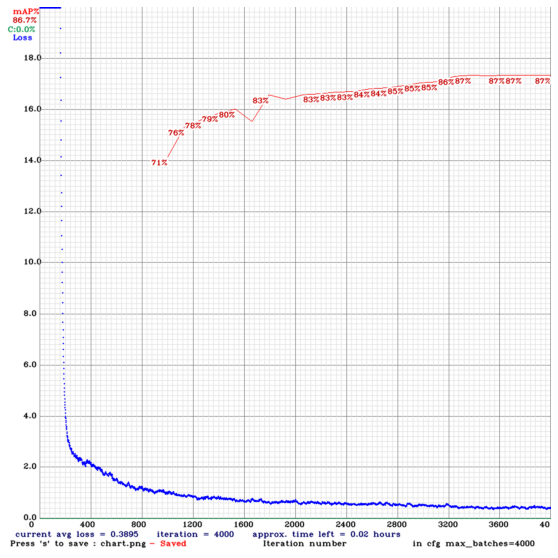

In [36]:
imShow("chart_yolov4-tiny.png")

## Check the model performance
The metrics run on the test images so they may not be fully representative, only indicative

In [37]:
!./darknet detector map /content/DeepCourse/obj.data /content/DeepCourse/yolov4-tiny.cfg "/content/darknet/backup/yolov4-tiny_best.weights" -points 0

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	                           ->  104 x 104 x 128 
   9 

## Run detection on an image. I choose one of the test images from test.txt

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	                           ->  104 x 104 x 128 
   9 

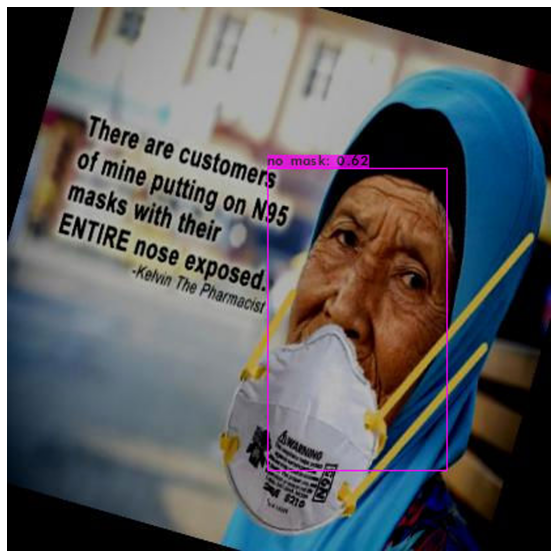

In [38]:
!./darknet detector test /content/DeepCourse/obj.data  /content/DeepCourse/yolov4-tiny.cfg  "/content/darknet/backup/yolov4-tiny_best.weights" /content/DeepCourse/obj/maksssksksss525_png.rf.ddd83ffdc59d9b7ebfc517f7431894aa.jpg -ext_output
imShow('predictions.jpg')

# Step 7: Running YOLOv4 on Video in the Cloud!

You can also run YOLOv4 object detections on video in your Google Colab VM. Follow the cells below to see how to run videos from your local machine or from your Google Drive! 

## Local Machine Video
Here is how to upload video from local machine, run detector and then download video showing detections.

In [39]:
!wget -O test.mp4 "https://github.com/ibaiGorordo/Social-Distance-Feedback/raw/master/Part%202%20-%20Mask%20Detection/Face%20Mask%20Detection%20Inference%20Comparison/videos/production%20ID_4236787.mp4"

--2021-02-05 18:03:25--  https://github.com/ibaiGorordo/Social-Distance-Feedback/raw/master/Part%202%20-%20Mask%20Detection/Face%20Mask%20Detection%20Inference%20Comparison/videos/production%20ID_4236787.mp4
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/ibaiGorordo/Social-Distance-Feedback-For-The-Blind/raw/master/Part%202%20-%20Mask%20Detection/Face%20Mask%20Detection%20Inference%20Comparison/videos/production%20ID_4236787.mp4 [following]
--2021-02-05 18:03:25--  https://github.com/ibaiGorordo/Social-Distance-Feedback-For-The-Blind/raw/master/Part%202%20-%20Mask%20Detection/Face%20Mask%20Detection%20Inference%20Comparison/videos/production%20ID_4236787.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ibaiGorordo/Social-Distance-

In [43]:
!./darknet detector demo /content/DeepCourse/obj.data  /content/DeepCourse/yolov4-tiny.cfg  "/content/drive/MyDrive/Tinyyolo/Tiny4BestWeights/yolov4-tiny_best.weights" -dont_show test.mp4 -i 0 -out_filename results.avi

Streaming output truncated to the last 5000 lines.


FPS:18.7 	 AVG_FPS:19.9

 cvWriteFrame 
Objects:


FPS:18.9 	 AVG_FPS:19.9

 cvWriteFrame 
Objects:


FPS:18.9 	 AVG_FPS:19.9

 cvWriteFrame 
Objects:

no mask: 30% 
no mask: 26% 

FPS:18.7 	 AVG_FPS:19.9

 cvWriteFrame 
Objects:

no mask: 44% 

FPS:18.9 	 AVG_FPS:19.9

 cvWriteFrame 
Objects:


FPS:19.0 	 AVG_FPS:19.9

 cvWriteFrame 
Objects:


FPS:19.7 	 AVG_FPS:19.9

 cvWriteFrame 
Objects:


FPS:19.1 	 AVG_FPS:19.9

 cvWriteFrame 
Objects:


FPS:19.2 	 AVG_FPS:19.9

 cvWriteFrame 
Objects:


FPS:20.3 	 AVG_FPS:19.9

 cvWriteFrame 
Objects:


FPS:20.3 	 AVG_FPS:19.9

 cvWriteFrame 
Objects:


FPS:20.7 	 AVG_FPS:19.9

 cvWriteFrame 
Objects:


FPS:20.6 	 AVG_FPS:19.9

 cvWriteFrame 
Objects:


FPS:20.8 	 AVG_FPS:19.9

 cvWriteFrame 
Objects:


FPS:20.9 	 AVG_FPS:19.9

 cvWriteFrame 
Objects:


FPS:20.1 	 AVG_FPS:19.9

 cvWriteFrame 
Objects:


FPS:19.8 	 AVG_FPS:19.9

 cvWriteFrame 
Objects:


FPS:19.2 	 AVG_FPS:19.9

 cvWriteFrame

In [44]:
# download the video with detections shown
from google.colab import files

video_path = 'results.avi'
files.download(video_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>